# Generate Slope, Aspect, hillshade

In [7]:
from osgeo import gdal
from osgeo import gdalconst

# Specify input DEM file path and output file paths
tile = 'T19GBP.tif'
dem_file = '/data/mboumahdi/dem/DEM_PREPARE/'+tile
slope_output_file = '/data/mboumahdi/dem/SLOPE_PREPARE/'+tile
aspect_output_file = '/data/mboumahdi/dem/ASPECT_PREPARE/'+tile
hillshade_output_file = '/data/mboumahdi/dem/HILLSHADE_PREPARE/'+tile

# Open the DEM dataset
dem_dataset = gdal.Open(dem_file, gdalconst.GA_ReadOnly)

# Calculate slope
gdal.DEMProcessing(slope_output_file, dem_dataset, 'slope')

# Calculate aspect
gdal.DEMProcessing(aspect_output_file, dem_dataset, 'aspect')

# Create hillshade
gdal.DEMProcessing(hillshade_output_file, dem_dataset, 'hillshade')

# Close the DEM dataset
dem_dataset = None


# Generate dataset

In [1]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.enums import Resampling
from rasterio.windows import Window

import glob
import os
from tqdm import tqdm
from datetime import datetime

import argparse


def bitwise_comparison(a, b):
    return np.bitwise_and(a, b) == b


def sliding_window(array, step_size, window_size):
    for _y in range(0, array.shape[0], step_size):
        for _x in range(0, array.shape[1], step_size):
            window = array[_y:_y + window_size, _x:_x + window_size]
            if (window.shape[0] != window_size) | (window.shape[1] != window_size):
                continue
            yield _x, _y, window

In [6]:

class MyStructure:
    def __init__(self,s2_preprocessed_dir, s1_preprocessed_dir,dem_dir,aspect_dir,slope_dir,hillshade_dir, type_reflectance, tile, s2_hours_difference,
               s2_s1_hours_difference,window_size, step_size,  roi_dir, threshold_roi, seed_value, train_ratio,
               val_ratio, test_ratio, threshold_target_cloud, threshold_input_cloud,output_dir):
        
        self.s2_preprocessed_dir = s2_preprocessed_dir
        self.s1_preprocessed_dir = s1_preprocessed_dir
        self.dem_dir = dem_dir
        self.aspect_dir = aspect_dir
        self.slope_dir = slope_dir
        self.hillshade_dir = hillshade_dir
        self.type_reflectance = type_reflectance
        self.tile = tile
        self.s2_hours_difference = s2_hours_difference
        self.s2_s1_hours_difference = s2_s1_hours_difference
        self.window_size = window_size
        self.step_size = step_size
        self.roi_dir = roi_dir
        self.threshold_roi = threshold_roi
        self.seed_value = seed_value
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.threshold_target_cloud = threshold_target_cloud
        self.threshold_input_cloud = threshold_input_cloud
        self.output_dir = output_dir
        


# Create an instance of the "structure" 18GYS 18GYT
args = MyStructure( '/data/mboumahdi/S2/S2_PREPARE/S2B',  '/data/mboumahdi/S1/S1_PREPARE','/data/mboumahdi/dem/DEM_PREPARE', 
                   '/data/mboumahdi/dem/ASPECT_PREPARE', '/data/mboumahdi/dem/SLOPE_PREPARE', '/data/mboumahdi/dem/HILLSHADE_PREPARE', 
                    'FRE', '18GYT',  168.0, 72.0, 256, 256,  '/data/mboumahdi/land_mask/', 1.0, 42,  0.8, 0.15, 0.05, 
                   0.0, 0.01,'/mnt/nvme1/dataset_S2B/')


if 1==1 :
    assert args.train_ratio + args.val_ratio + args.test_ratio == 1.0, 'train_ratio + val_ratio + test_ratio != 1.0'

    np.random.seed(args.seed_value)

    s2_files = glob.glob(f'{args.s2_preprocessed_dir}/T{args.tile}/*/*{args.tile}*{args.type_reflectance}_10m.tif')
    s1_files = glob.glob(f'{args.s1_preprocessed_dir}/T{args.tile}/*{args.tile}*_from-10to3dB.tif')

    dates_s2 = [datetime.strptime(os.path.basename(f).split('_')[1],
                                           '%Y%m%d-%H%M%S-%f') for f in s2_files]
    dates_s1 = [datetime.strptime(f.split('_')[6].split('t')[0], '%Y%m%d') for f in s1_files]

    df_s2 = pd.DataFrame({'S2': s2_files})
    df_s1 = pd.DataFrame({'S1': s1_files})

    df_s2['date_s2'] = dates_s2
    df_s1['date_s1'] = dates_s1

    df_s2 = df_s2.sort_values(by=['date_s2'])
    df_s1 = df_s1.sort_values(by=['date_s1'])

    # calculate distance between two sentinel-2 images in hours
    df_s2['lagged_times'] = df_s2['date_s2'].shift()
    df_s2['time_difference_seconds'] = (df_s2['date_s2'] - df_s2['lagged_times']).dt.total_seconds()
    df_s2['s2_time_difference_hours'] = df_s2['time_difference_seconds'] / 3600
    df_s2['previous_s2'] = df_s2['S2'].shift()
    df_s2['previous_date'] = df_s2['date_s2'].shift()

    df_s2 = df_s2[['S2', 'date_s2', 'previous_s2', 'previous_date', 's2_time_difference_hours']]
    df_s2 = df_s2[1:]  # remove first row
    # TODO: check if to remove the last one (No need to)
    # calculate distance between sentinel-1 and sentinel-2 images in hours
    df_s2_s1 = pd.merge_asof(df_s2, df_s1, left_on='previous_date', right_on='date_s1',
                             direction='nearest', allow_exact_matches=False)
    df_s2_s1 = df_s2_s1[['S2', 'date_s2', 'previous_s2', 'previous_date',
                         's2_time_difference_hours', 'S1', 'date_s1']]
    df_s2_s1['s2_s1_time_difference_hours'] = np.abs((df_s2_s1['previous_date'] -
                                                      df_s2_s1['date_s1']).dt.total_seconds() / 3600)

    df_s2_s1_filtered = df_s2_s1[(df_s2_s1.s2_time_difference_hours <= args.s2_hours_difference) &
                                 (df_s2_s1.s2_s1_time_difference_hours <= args.s2_s1_hours_difference)]

    df_s2_s1_filtered.to_csv(f'S2B/{args.tile}_s2_s1_filtered_images_{args.s2_hours_difference}_'
                             f'{args.s2_s1_hours_difference}.csv',
                             index=False)
    
if 1==1 :
    area = args.window_size ** 2
    sampling = []
    #TODO: check the name of the roi.tif image corresponding to the land mask (full resolution) 10m
    roi_raster = rasterio.open(f'{args.roi_dir}/T{args.tile}_ROI.tif').read(1)

    for _x, _y, window in sliding_window(roi_raster, step_size=args.step_size, window_size=args.window_size):
        percentage = np.sum(window)/area
        if percentage < args.threshold_roi:
            continue
        sampling.append([_x, _y, percentage])

    df_sampling = pd.DataFrame(sampling, columns=['x', 'y', 'percentage'])

    x = df_sampling.x.values
    y = df_sampling.y.values

    indices = np.arange(x.shape[0])

    # Calculate the number of samples for each set
    num_samples = len(indices)
    num_train = int(args.train_ratio * num_samples)
    num_val = int(args.val_ratio * num_samples)
    num_test = num_samples - num_train - num_val

    # Shuffle the indices
    np.random.shuffle(indices)

    # Split the indices into train, validation, and test sets
    train_indices = indices[:num_train]
    val_indices = indices[num_train:num_train + num_val]
    test_indices = indices[num_train + num_val:]

    df_sampling['set'] = ''
    df_sampling.loc[train_indices, 'set'] = 'train'
    df_sampling.loc[val_indices, 'set'] = 'validation'
    df_sampling.loc[test_indices, 'set'] = 'test'

    df_sampling.to_csv(f'S2B/{args.tile}_roi_{args.threshold_roi}_{args.window_size}_'
                       f'{args.step_size}_sampling.csv', index=False)
    #TODO: check that set appear in all the below csv file like train ........ validation ..... test (it does exist)
    # Create database


In [7]:
if 1 ==1:
    database = []

    for idx1, row1 in tqdm(df_s2_s1_filtered.iterrows(), total=df_s2_s1_filtered.shape[0]):
        input_s2 = row1['previous_s2']
        input_s1 = row1['S1']
        target_s2 = row1['S2']
        date_s2 = row1['previous_date']
        date_s2 = str(date_s2)[:4] + str(date_s2)[5:7] + str(date_s2)[8:10] # Year month day YYYYmmdd style

        clm_1_path = input_s2.replace(f'_{args.type_reflectance}_10m.tif', '_CLM_R1.tif')
        clm_mask_1 = rasterio.open(clm_1_path).read(1)
        edg_1_path = input_s2.replace(f'_{args.type_reflectance}_10m.tif', '_EDG_R1.tif')
        edg_mask_1 = rasterio.open(edg_1_path).read(1)

        clm_2_path = target_s2.replace(f'_{args.type_reflectance}_10m.tif', '_CLM_R1.tif')
        clm_mask_2 = rasterio.open(clm_2_path).read(1)
        edg_2_path = target_s2.replace(f'_{args.type_reflectance}_10m.tif', '_EDG_R1.tif')
        edg_mask_2 = rasterio.open(edg_2_path).read(1)

        s1_mask = (rasterio.open(input_s1).read() == 0).astype(np.uint16)
        s1_mask = np.sum(s1_mask, axis=0)

        for idx2, row2 in df_sampling.iterrows():
            #TODO: get the set (to see train valid and test)
            x = int(row2['x'])
            y = int(row2['y'])
            set_name = row2['set'] ## check if it exist in the csv
            #TODO: check it [x,y] or [y,x]
            edg_1_patch = edg_mask_1[y:y + args.window_size, x:x + args.window_size]
            clm_1_patch = clm_mask_1[y:y + args.window_size, x:x + args.window_size]

            edg_2_patch = edg_mask_2[y:y + args.window_size, x:x + args.window_size]
            clm_2_patch = clm_mask_2[y:y + args.window_size, x:x + args.window_size]

            s1_mask_patch = s1_mask[y:y + args.window_size, x:x + args.window_size]

            if np.sum(edg_1_patch) != 0: #TODO: check if edg mask , 0 in valid 
                continue

            if np.sum(edg_2_patch) != 0:
                continue

            if np.sum(s1_mask_patch) > 0:
                continue

            cloud_s2_input = np.sum(clm_1_patch != 0) / area
            cloud_s2_target = np.sum(clm_2_patch != 0) / area
            #TODO: add the set name
            database.append([input_s2, input_s1, target_s2, cloud_s2_input,
                             cloud_s2_target, x, y, date_s2, set_name])
    #TODO: add the set name
    df_database = pd.DataFrame(database, columns=['s2_input', 's1_input', 's2_target',
                                                  'cloud_s2_input', 'cloud_s2_target',
                                                  'x', 'y', 'date_s2','set'])
    # TODO: Verify if the threshold is correct
    df_database = df_database[(df_database.cloud_s2_input >= args.threshold_input_cloud) &
                              (df_database.cloud_s2_target <= args.threshold_target_cloud)]

    df_database.to_csv(f'S2B/{args.tile}_database_{args.threshold_roi}_{args.window_size}_'
                       f'{args.step_size}_sampling.csv', index=False)
    


100%|██████████| 91/91 [06:13<00:00,  4.11s/it]


In [8]:
if 1==1 :
    dataset = []

    for idx, row in tqdm(df_database.iterrows(), total=df_database.shape[0]):
        #TODO: add the set name
        input_s2 = row['s2_input']
        input_s1 = row['s1_input']
        target_s2 = row['s2_target']
        cloud_s2_input = row['cloud_s2_input']
        cloud_s2_target = row['cloud_s2_target']
        x = int(row['x'])
        y = int(row['y'])
        date_s2 = row['date_s2']
        set_name = row['set']

        window_10m = Window(x, y, args.window_size, args.window_size)
        window_20m = Window(x // 2, y // 2, args.window_size // 2, args.window_size // 2)

        s2_cloud_mask_src = rasterio.open(input_s2.replace(f'_{args.type_reflectance}_10m.tif',
                                                           '_CLM_R1.tif'))

        s2_10m_input_src = rasterio.open(input_s2)
        s2_20m_input_src = rasterio.open(input_s2.replace('10m', '20m'))

        s2_10m_target_src = rasterio.open(target_s2)
        s2_20m_target_src = rasterio.open(target_s2.replace('10m', '20m'))

        s1_10m_input_src = rasterio.open(input_s1)
        dem_20m_input_src = rasterio.open(f'{args.dem_dir}/T{args.tile}.tif')

        aspect_20m_input_src = rasterio.open(f'{args.aspect_dir}/T{args.tile}.tif')
        slope_20m_input_src = rasterio.open(f'{args.slope_dir}/T{args.tile}.tif')
        hillshade_20m_input_src = rasterio.open(f'{args.hillshade_dir}/T{args.tile}.tif')
        
        s2_cloud_mask = s2_cloud_mask_src.read(window=window_10m)

        s2_10m_input = s2_10m_input_src.read(window=window_10m)
        s2_20m_input = s2_20m_input_src.read(window=window_20m)

        s2_10m_target = s2_10m_target_src.read(window=window_10m)
        s2_20m_target = s2_20m_target_src.read(window=window_20m)

        s1_10m_input = s1_10m_input_src.read(window=window_10m)
        dem_20m_input = dem_20m_input_src.read(window=window_20m)
        
        aspect_20m_input = aspect_20m_input_src.read(window=window_20m)
        slope_20m_input = slope_20m_input_src.read(window=window_20m)
        hillshade_20m_input = hillshade_20m_input_src.read(window=window_20m)

        filename = f'{args.tile}_{date_s2}_{x}_{y}'

        kwargs = s2_10m_input_src.meta.copy()
        kwargs.update({
            'height': window_10m.height,
            'width': window_10m.width,
            'transform': rasterio.windows.transform(window_10m, s2_10m_input_src.transform)
        })
        with rasterio.open(f'{args.output_dir}/{filename}_input_s2.tif', 'w', **kwargs) as dst:
            dst.write(s2_10m_input)
        with rasterio.open(f'{args.output_dir}/{filename}_target_s2.tif', 'w', **kwargs) as dst:
            dst.write(s2_10m_target)
        ## genrate S1
        kwargs = s1_10m_input_src.meta.copy()
        kwargs.update({
            'height': window_10m.height,
            'width': window_10m.width,
            'transform': rasterio.windows.transform(window_10m, s2_10m_input_src.transform)
        })

        with rasterio.open(f'{args.output_dir}/{filename}_input_s1.tif', 'w', **kwargs) as dst:
            dst.write(s1_10m_input)
            
        #Generate cloud mask
        kwargs = s2_cloud_mask_src.meta.copy()
        kwargs.update({
            'height': window_10m.height,
            'width': window_10m.width,
            'transform': rasterio.windows.transform(window_10m, s2_10m_input_src.transform)
        })
        with rasterio.open(f'{args.output_dir}/{filename}_cloud_s2.tif', 'w', **kwargs) as dst:
            dst.write(s2_cloud_mask)

        ##Generate S2 20m
        kwargs = s2_20m_input_src.meta.copy()
        kwargs.update({
            'height': window_20m.height,
            'width': window_20m.width,
            'transform': rasterio.windows.transform(window_20m, s2_20m_input_src.transform)
        })
        with rasterio.open(f'{args.output_dir}/{filename}_input_s2_20m.tif', 'w', **kwargs) as dst:
            dst.write(s2_20m_input)
        with rasterio.open(f'{args.output_dir}/{filename}_target_s2_20m.tif', 'w', **kwargs) as dst:
            dst.write(s2_20m_target)
       
        ## Generate dem
        kwargs.update({
            'count': 1,
        })
        with rasterio.open(f'{args.output_dir}/{filename}_input_dem_20m.tif', 'w', **kwargs) as dst:
            dst.write(dem_20m_input)
            
        with rasterio.open(f'{args.output_dir}/{filename}_input_aspect_20m.tif', 'w', **kwargs) as dst:
            dst.write(aspect_20m_input)
        with rasterio.open(f'{args.output_dir}/{filename}_input_slope_20m.tif', 'w', **kwargs) as dst:
            dst.write(slope_20m_input)
        with rasterio.open(f'{args.output_dir}/{filename}_input_hillshade_20m.tif', 'w', **kwargs) as dst:
            dst.write(hillshade_20m_input)
        #TODO: add set name 
        dataset.append([filename, input_s2, input_s1, target_s2, cloud_s2_input,
                        cloud_s2_target, x, y, date_s2, set_name])
    print(f'{args.output_dir}/{filename}_input_hillshade_20m.tif')
    df_dataset = pd.DataFrame(dataset, columns=['filename', 's2_input', 's1_input', 's2_target',
                                                'cloud_s2_input', 'cloud_s2_target', 'x', 'y',
                                                'date_s2','set'])
    df_dataset.to_csv(f'S2B/{args.tile}_dataset_{args.threshold_roi}_{args.window_size}_'
                      f'{args.step_size}.csv', index=False)



100%|██████████| 3373/3373 [02:32<00:00, 22.13it/s]

/mnt/nvme1/dataset_S2B//18GYT_20220525_0_10240_input_hillshade_20m.tif


In [31]:
f'{args.tile}_dataset_{args.threshold_roi}_{args.window_size}_'f'{args.step_size}.csv'

'18GYS_dataset_1.0_256_256.csv'

## Join the csv

In [9]:
import csv
file1 = 'S2B/18GXS_dataset_1.0_256_256.csv'
file2 = 'S2B/18GXT_dataset_1.0_256_256.csv'
file3 = 'S2B/18GXU_dataset_1.0_256_256.csv'
file4 = 'S2B/18GYR_dataset_1.0_256_256.csv'
file5 = 'S2B/18GYS_dataset_1.0_256_256.csv'
file6 = 'S2B/18GYT_dataset_1.0_256_256.csv'
file7 = 'S2B/19GBP_dataset_1.0_256_256.csv'
# Read data from the first CSV file


csv_content1 = []
with open(file1, 'r', newline='') as file1:
    reader = csv.reader(file1)
    csv_content1.extend(list(reader))

csv_content2 = []
with open(file2, 'r', newline='') as file2:
    reader = csv.reader(file2)
    csv_content2.extend(list(reader))

csv_content3 = []
with open(file3, 'r', newline='') as file3:
    reader = csv.reader(file3)
    csv_content3.extend(list(reader))
    
csv_content4 = []
with open(file4, 'r', newline='') as file4:
    reader = csv.reader(file4)
    csv_content4.extend(list(reader))
    
csv_content5 = []
with open(file5, 'r', newline='') as file5:
    reader = csv.reader(file5)
    csv_content5.extend(list(reader))
    
csv_content6 = []
with open(file6, 'r', newline='') as file6:
    reader = csv.reader(file6)
    csv_content6.extend(list(reader))
    
csv_content7 = []
with open(file7, 'r', newline='') as file7:
    reader = csv.reader(file7)
    csv_content7.extend(list(reader))
    
       
combined_csv_content = csv_content1 + csv_content2 + csv_content3 + csv_content4 + csv_content5 + csv_content6 + csv_content7

with open('Tiles_dataset_S2B_1.0_256_256.csv', 'w', newline='') as combined_file:
    writer = csv.writer(combined_file)
    writer.writerows(combined_csv_content)

In [10]:
print(len(csv_content1)+len(csv_content2)+len(csv_content3)+len(csv_content4)+len(csv_content5)+len(csv_content6)+len(csv_content7))
print(len(combined_csv_content))

29733
29733


# Dataset loader

In [1]:
from torch.utils.data import Dataset
import numpy as np
import rasterio
from rasterio.enums import Resampling
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

S2_UNSCALE_COEF = 10000.0
S2_SCALE_COEF = 1.0 / S2_UNSCALE_COEF
DEM_SCALE_COEF = 0.0001
S1_UNSCALE_COEF = 65535.0
S1_SCALE_COEF = 1 / S1_UNSCALE_COEF


def get_transforms(subset):
    # image: s2_10m_input, image0: s2_10m_output, image1: s2_20m_input, image2: s2_20m_output,
    # image3: s1_10m, image4: dem
    if subset == 'train':
        transform = A.Compose([
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            ToTensorV2()
        ], additional_targets={'image0': 'image', 'image1': 'image', 'image2': 'image',
                               'image3': 'image', 'image4': 'image'}, is_check_shapes=False)
    else:
        transform = A.Compose([
            ToTensorV2()
        ], additional_targets={'image0': 'image', 'image1': 'image', 'image2': 'image',
                               'image3': 'image', 'image4': 'image'}, is_check_shapes=False)
    return transform


class SentinelDataset(Dataset):
    def __init__(self, filepath, files: np.array, subset='train') -> None:
        self.filepath = filepath
        self.samples = files
        self.transform = get_transforms(subset)

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> dict:
        sample = self.samples[idx]
        #print(sample)
        # TODO: Check all
        s2_10m_cloudy = rasterio.open(f'{self.filepath}/{sample}_input_s2.tif').read()
        s2_10m_cloudy = s2_10m_cloudy.astype(np.float32) * S2_SCALE_COEF
        s2_10m_cloudy = np.rollaxis(s2_10m_cloudy, 0, 3)

        #print('s2_10m_cloudy', s2_10m_cloudy.shape)

        s2_10m_no_cloudy = rasterio.open(f'{self.filepath}/{sample}_target_s2.tif').read()
        s2_10m_no_cloudy = s2_10m_no_cloudy.astype(np.float32) * S2_SCALE_COEF
        s2_10m_no_cloudy = np.rollaxis(s2_10m_no_cloudy, 0, 3)

        #print('s2_10m_no_cloudy', s2_10m_no_cloudy.shape)

        s1_10m = rasterio.open(f'{self.filepath}/{sample}_input_s1.tif').read()
        s1_10m = s1_10m.astype(np.float32) * S1_SCALE_COEF
        s1_10m = np.rollaxis(s1_10m, 0, 3)

        #print('s1_10m', s1_10m.shape)

        s2_20m_cloudy_src = rasterio.open(f'{self.filepath}/{sample}_input_s2_20m.tif')
        s2_20m_cloudy = s2_20m_cloudy_src.read(
            out_shape=(
                s2_20m_cloudy_src.count,
                int(s2_20m_cloudy_src.height * 2),
                int(s2_20m_cloudy_src.width * 2)
            ),
            resampling=Resampling.nearest
        )
        s2_20m_cloudy = s2_20m_cloudy.astype(np.float32) * S2_SCALE_COEF
        s2_20m_cloudy = np.rollaxis(s2_20m_cloudy, 0, 3)

        #print('s2_20m_cloudy', s2_20m_cloudy.shape)

        s2_20m_no_cloudy_src = rasterio.open(f'{self.filepath}/{sample}_target_s2_20m.tif')
        s2_20m_no_cloudy = s2_20m_no_cloudy_src.read(
            out_shape=(
                s2_20m_no_cloudy_src.count,
                int(s2_20m_no_cloudy_src.height * 2),
                int(s2_20m_no_cloudy_src.width * 2)
            ),
            resampling=Resampling.nearest
        )
        s2_20m_no_cloudy = s2_20m_no_cloudy.astype(np.float32) * S2_SCALE_COEF
        s2_20m_no_cloudy = np.rollaxis(s2_20m_no_cloudy, 0, 3)

        #print('s2_20m_no_cloudy', s2_20m_no_cloudy.shape)

        dem = rasterio.open(f'{self.filepath}/{sample}_input_dem_20m.tif').read()
        dem = dem.astype(np.float32) * DEM_SCALE_COEF
        dem = np.rollaxis(dem, 0, 3)

        #print('dem', dem.shape)

        cloud_mask = rasterio.open(f'{self.filepath}/{sample}_cloud_s2.tif').read()
        cloud_mask = np.rollaxis(cloud_mask, 0, 3)

        #print('cloud_mask', cloud_mask.shape)

        if self.transform:
            data = self.transform(image=s2_10m_cloudy, image0=s2_10m_no_cloudy, image1=s2_20m_cloudy,
                                  image2=s2_20m_no_cloudy, image3=s1_10m, image4=dem, mask=cloud_mask)
        else:
            data = {'image': s2_10m_cloudy, 'image0': s2_10m_no_cloudy, 'image1': s2_20m_cloudy,
                    'image2': s2_20m_no_cloudy, 'image3': s1_10m, 'image4': dem, 'mask': cloud_mask}

        return {'s2_10m_input': data['image'], 's2_10m_output': data['image0'], 's2_20m_input': data['image1'],
                's2_20m_output': data['image2'], 's1_10m': data['image3'], 'dem': data['image4'],
                'cloud_mask': data['mask']}


# Unet 

In [2]:
import torch
import torch.nn as nn
import timm


class Sentinel12UNet(nn.Module):
    def __init__(self, include_s1=True, include_s2_20m=True, include_dem_20m=True):
        super(Sentinel12UNet, self).__init__()

        s2_10m_channels = 4
        s1_10m_channels = 2 if include_s1 else 0
        s2_20m_in_channels = 6 if include_s2_20m else 0
        dem_20m_in_channels = 1 if include_dem_20m else 0

        in_channels = s2_10m_channels + s1_10m_channels + s2_20m_in_channels
        out_channels = s2_10m_channels + s2_20m_in_channels

        # U-Net encoder
        self.conv1 = self._make_conv_block(in_channels, 64)
        self.conv2 = self._make_conv_block(64 + dem_20m_in_channels, 128)
        self.conv3 = self._make_conv_block(128, 256)
        self.conv4 = self._make_conv_block(256, 512)
        self.conv5 = self._make_conv_block(512, 1024)

        # U-Net decoder
        self.upconv1 = self._make_upconv(1024, 512)
        self.upconv2 = self._make_upconv(512 + 512, 256)
        self.upconv3 = self._make_upconv(256 + 256, 128)
        self.upconv4 = self._make_upconv(128 + 128, 64)

        # Final output
        self.out = nn.Conv2d(64 + 64, out_channels, kernel_size=1)

    def _make_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def _make_upconv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, s2_10, s2_20, s1_10, dem_20):
        # ResNet encoder
        x = torch.cat([s2_10, s2_20, s1_10], 1)

        # Encoder
        conv1 = self.conv1(x)
        pool1 = nn.MaxPool2d(kernel_size=2)(conv1)
        conv2 = self.conv2(torch.cat([pool1, dem_20], 1))
        pool2 = nn.MaxPool2d(kernel_size=2)(conv2)
        conv3 = self.conv3(pool2)
        pool3 = nn.MaxPool2d(kernel_size=2)(conv3)
        conv4 = self.conv4(pool3)
        pool4 = nn.MaxPool2d(kernel_size=2)(conv4)
        conv5 = self.conv5(pool4)

        # Decoder
        upconv1 = self.upconv1(conv5)
        concat1 = torch.cat([upconv1, conv4], dim=1)
        upconv2 = self.upconv2(concat1)
        concat2 = torch.cat([upconv2, conv3], dim=1)
        upconv3 = self.upconv3(concat2)
        concat3 = torch.cat([upconv3, conv2], dim=1)
        upconv4 = self.upconv4(concat3)
        concat4 = torch.cat([upconv4, conv1], dim=1)
        # Output
        out = self.out(concat4)
        return out


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # U-Net encoder
        self.conv1 = self._make_conv_block(in_channels, 64)
        self.conv2 = self._make_conv_block(64, 128)
        self.conv3 = self._make_conv_block(128, 256)
        self.conv4 = self._make_conv_block(256, 512)
        self.conv5 = self._make_conv_block(512, 1024)

        # U-Net decoder
        self.upconv1 = self._make_upconv(1024, 512)
        self.upconv2 = self._make_upconv(512, 256)
        self.upconv3 = self._make_upconv(256, 128)
        self.upconv4 = self._make_upconv(128, 64)

        # Final output
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def _make_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def _make_upconv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        conv1 = self.conv1(x)
        pool1 = nn.MaxPool2d(kernel_size=2)(conv1)
        conv2 = self.conv2(pool1)
        pool2 = nn.MaxPool2d(kernel_size=2)(conv2)
        conv3 = self.conv3(pool2)
        pool3 = nn.MaxPool2d(kernel_size=2)(conv3)
        conv4 = self.conv4(pool3)
        pool4 = nn.MaxPool2d(kernel_size=2)(conv4)
        conv5 = self.conv5(pool4)

        # Decoder
        upconv1 = self.upconv1(conv5)
        concat1 = torch.cat([upconv1, conv4], dim=1)
        upconv2 = self.upconv2(concat1)
        concat2 = torch.cat([upconv2, conv3], dim=1)
        upconv3 = self.upconv3(concat2)
        concat3 = torch.cat([upconv3, conv2], dim=1)
        upconv4 = self.upconv4(concat3)
        concat4 = torch.cat([upconv4, conv1], dim=1)
        # Output
        out = self.out(concat4)
        return out


class UNetResNet(nn.Module):
    def __init__(self, in_channels, out_channels, resnet_arch='resnet50',
                 pretrained=True):
        super(UNetResNet, self).__init__()

        # Load the ResNet encoder
        self.encoder = timm.create_model(resnet_arch, pretrained=pretrained,
                                         in_chans=in_channels)
        encoder_features = list(self.encoder.children())
        seq_layers = [f for f in encoder_features if isinstance(f, nn.Sequential)]

        self.encoder_features = [nn.Sequential(*encoder_features[:3]),
                                 nn.Sequential(encoder_features[3], seq_layers[0]),
                                 seq_layers[1], seq_layers[2], seq_layers[3]]

        # U-Net decoder
        self.upconv1 = self._make_upconv(2048, 1024)
        self.upconv2 = self._make_upconv(1024 + 1024, 512)
        self.upconv3 = self._make_upconv(512 + 512, 256)
        self.upconv4 = self._make_upconv(256 + 256, 64)
        self.upconv5 = self._make_upconv(64 + 64, 64)
        self.conv_out = nn.Conv2d(64, out_channels, kernel_size=1)

    def _make_upconv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3,
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # ResNet encoder
        x1 = self.encoder_features[0](x)
        x2 = self.encoder_features[1](x1)
        x3 = self.encoder_features[2](x2)
        x4 = self.encoder_features[3](x3)
        x5 = self.encoder_features[4](x4)

        # U-Net decoder
        x = self.upconv1(x5)
        x = self.upconv2(torch.cat([x, x4], 1))
        x = self.upconv3(torch.cat([x, x3], 1))
        x = self.upconv4(torch.cat([x, x2], 1))
        x = self.upconv5(torch.cat([x, x1], 1))

        # Output
        x = self.conv_out(x)
        return x


if __name__ == '__main__':
    # Example usage
    in_channels = 5  # Number of input bands
    out_channels = 3  # Number of output channels
    model = UNetResNet(in_channels, out_channels)

    # Create dummy input (batch size of 1, 5 input channels, 256x256 resolution)
    dummy_input = torch.randn(1, in_channels, 256, 256)
    # Forward pass
    output = model(dummy_input)
    print(output.shape)  # Check the shape of the output


torch.Size([1, 3, 256, 256])


# Run the model

In [7]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import argparse
from tqdm import tqdm
import time
import os
import math
import random
from skimage.transform import resize
from scipy.ndimage import rotate

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import torchmetrics
from torchmetrics.image.psnr import PeakSignalNoiseRatio
from torchmetrics.regression import MeanSquaredError
#from model.networks.deeplabv3plus import DeepLabV3Plus
#from model.losses.loss import FocalTverskyLoss

from datetime import datetime

#from data.asbestos import AsbestosDataset

from sklearn.model_selection import train_test_split

from tools.utils import save_checkpoint, load_checkpoint

import warnings
warnings.filterwarnings("ignore")

# set flags / seeds
SEED = 5
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

## function
def to_tensor(x, **kwargs):
    return torch.from_numpy(x.transpose(2, 0, 1).astype('float32'))



class RandomCrop(object):
    def __init__(self, crop_size, p=0.5):
        self.crop_size = crop_size
        self.p = p

    def __call__(self, **data):
        image = data['image']
        mask = data['mask']

        if np.random.rand() <= self.p:
            h, w = image.shape[:2]
            new_h, new_w = self.crop_size
            top = np.random.randint(0, h - new_h)
            left = np.random.randint(0, w - new_w)

            image = image[top: top + new_h, left: left + new_w]
            mask = mask[top: top + new_h, left: left + new_w]

        return {'image': image, 'mask': mask}
    

class MyStructureMain:
    def __init__(self,lr, resume, data_dir, csv_file, path_to_checkpoint, path_to_save_models,epochs, batch_size, num_workers):
        
        self.lr = lr
        self.resume = resume
        self.data_dir = data_dir
        self.csv_file = csv_file
        self.path_to_checkpoint = path_to_checkpoint
        self.path_to_save_models = path_to_save_models
        self.epochs = epochs
        self.batch_size = batch_size
        self.num_workers = num_workers



# Create an instance of the "structure"
opt = MyStructureMain(0.0002, False, '/mnt/nvme1/dataset', '/data/mboumahdi/codes/18GXS_18GYS_dataset_1.0_256_256.csv', 
                      '','/mnt/nvme1/models_decloud/', 300, 4,1 )


# Start with main code
if __name__ == '__main__':
    # argparse for additional flags for experiment
    df = pd.read_csv(opt.csv_file)
    df_train = df[df['set'] == 'train']
    df_valid = df[df['set'] == 'validation']
    df_test = df[df['set'] == 'test']
    
    df_train = df_train.reset_index(drop=True)
    df_valid = df_valid.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    
    dataset_train = SentinelDataset(opt.data_dir, df_train['filename'], subset='train')  # You can adjust subset
    dataset_test  = SentinelDataset(opt.data_dir, df_test['filename'], subset = 'test')  # You can adjust subset
    dataset_valid = SentinelDataset(opt.data_dir, df_valid['filename'], subset='valid')  # You can adjust subset

    dataloader_train = DataLoader(dataset_train, batch_size=opt.batch_size, shuffle=True,
                                    drop_last=True, num_workers=opt.num_workers, pin_memory=True)
    dataloader_val = DataLoader(dataset_valid, batch_size=opt.batch_size, shuffle=False,
                                    num_workers=opt.num_workers, pin_memory=True)
    dataloader_test = DataLoader(dataset_test, batch_size=opt.batch_size, shuffle=False,
                                    num_workers=opt.num_workers, pin_memory=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Sentinel12UNet().to(device)
    date = datetime.now().strftime('%Y-%m-%d_%f')
    project_name = f'Sentinel12UNet_18GXS_18GYS_EarlyStop_{date}'
    
    log_dir = os.path.join(opt.path_to_save_models, project_name)

# Create the SummaryWriter with the specified log directory and filename_suffix
    writer = SummaryWriter(log_dir, filename_suffix=project_name)
    
    
    #writer = SummaryWriter(f'./runs/{project_name}', filename_suffix=project_name)
    s2_10 = torch.randn([1, 4, 64, 64]).to(device)
    s2_20 = torch.randn([1, 6, 64, 64]).to(device)
    s1_10 = torch.randn([1, 2, 64, 64]).to(device)
    dem_20 = torch.randn([1, 1, 32, 32]).to(device)
    writer.add_graph(model, input_to_model=(s2_10, s2_20, s1_10, dem_20))
    
    metric = MeanSquaredError().to(device)
    criterion = nn.L1Loss()
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=opt.lr, weight_decay=1e-4)
# load checkpoint if needed/ wanted
    start_n_iter = 0
    start_epoch = 1
    if opt.resume:
        ckpt = load_checkpoint(opt.path_to_checkpoint)  # custom method for loading last checkpoint
        model.load_state_dict(ckpt['model'])
        start_epoch = ckpt['epoch']
        start_n_iter = ckpt['n_iter']
        optimizer.load_state_dict(ckpt['optim'])
        print("last checkpoint restored")

    # now we start the main loop
    n_iter = start_n_iter
    best_val_loss = np.inf
    patience = 5
    trigger_times = 0
    
    epochs = opt.epochs
    
    
    for epoch in range(start_epoch, opt.epochs + 1):
        n_iter = n_iter + 1
        # set models to train mode
        model.train()

        # use prefetch_generator and tqdm for iterating through data
        pbar = tqdm(enumerate(dataloader_train),
                    total=len(dataloader_train))

        start_time = time.time()

        # for loop going through dataset
        running_train_loss = 0

        for i, data in pbar:
            s2_10_input = data['s2_10m_input'].to(device)
            s2_20_input = data['s2_20m_input'].to(device)
            s1_10 = data['s1_10m'].to(device)
            dem_20 = data['dem'].to(device)

            s2_10_output = data['s2_10m_output'].to(device)
            s2_20_output = data['s2_20m_output'].to(device)

            y = torch.cat([s2_10_output, s2_20_output], 1)

            # It's very good practice to keep track of preparation time and
            # computation time using tqdm to find any issues in your dataloader
            prepare_time = start_time - time.time()

            # forward and backward pass
            y_hat = model(s2_10_input, s2_20_input, s1_10, dem_20)

            loss = criterion(y_hat, y)  # TODO: check order parameters

            running_train_loss += loss.item()

            # backward
            optimizer.zero_grad(set_to_none=True)

            loss.backward()

            optimizer.step()

            # compute computation time and *compute_efficiency*
            process_time = start_time - time.time() - prepare_time
            compute_efficiency = process_time / (process_time + prepare_time)
            pbar.set_description(
                f'Train. Compute efficiency: {compute_efficiency:.2f}, '
                f'loss: {loss.item():.6f},  epoch: {epoch}/{epochs}')
            start_time = time.time()

        # update tensorboard
        writer.add_scalar("Loss/train", running_train_loss / len(dataloader_train), n_iter)

        model.eval()  # evaluation mode

        ###### Validation
        running_val_loss = 0.0
        running_val_acc = 0.0
        pbar = tqdm(enumerate(dataloader_val), total=len(dataloader_val))
        with torch.no_grad():
            for i, data in pbar:
                # data preparation
                s2_10_input = data['s2_10m_input'].to(device)
                s2_20_input = data['s2_20m_input'].to(device)
                s1_10 = data['s1_10m'].to(device)
                dem_20 = data['dem'].to(device)

                s2_10_output = data['s2_10m_output'].to(device)
                s2_20_output = data['s2_20m_output'].to(device)

                y = torch.cat([s2_10_output, s2_20_output], 1)

                y_hat = model(s2_10_input, s2_20_input, s1_10, dem_20)
                loss = criterion(y_hat, y)  # TODO: check order parameters

                acc_value = metric(y_hat, y)

                running_val_loss += loss.item()
                running_val_acc += acc_value

                pbar.set_description(
                    f'Validation. Loss: {loss.item():.6f}, accuracy: {acc_value:.6f}, epoch: {epoch}/{epochs}')

            writer.add_scalar("Loss/validation", running_val_loss / len(dataloader_val), n_iter)
            writer.add_scalar("Accuracy/validation", running_val_acc / len(dataloader_val), n_iter)
            
            '''
            if running_val_loss >= best_val_loss:
                trigger_times += 1
                if trigger_times >= patience:
                    break
            elif running_val_loss < best_val_loss:
                best_val_loss = running_val_loss
                trigger_times = 0
                cpkt = {
                    'model': model.state_dict(),
                    'epoch': epoch,
                    'n_iter': n_iter,
                    'optim': optimizer.state_dict(),
                }
            '''
                best_val_loss = running_val_loss
                trigger_times = 0
                cpkt = {
                    'model': model.state_dict(),
                    'epoch': epoch,
                    'n_iter': n_iter,
                    'optim': optimizer.state_dict(),
                }
            
                save_checkpoint(cpkt, os.path.join(opt.path_to_save_models, f'{project_name}.ckpt'))

                if epoch % 1 == 0:
                    pbar = tqdm(enumerate(dataloader_test), total=len(dataloader_test))

                    running_test_acc = 0.0
                    for i, data in pbar:
                        # data preparation
                        s2_10_input = data['s2_10m_input'].to(device)
                        s2_20_input = data['s2_20m_input'].to(device)
                        s1_10 = data['s1_10m'].to(device)
                        dem_20 = data['dem'].to(device)

                        s2_10_output = data['s2_10m_output'].to(device)
                        s2_20_output = data['s2_20m_output'].to(device)

                        y = torch.cat([s2_10_output, s2_20_output], 1)

                        y_hat = model(s2_10_input, s2_20_input, s1_10, dem_20)
                        loss = criterion(y_hat, y)  # TODO: check order parameters

                        acc_value = metric(y_hat, y)

                        running_test_acc += acc_value

                        pbar.set_description(
                            f'Test Accuracy: {acc_value:.6f},  epoch: {epoch}/{epochs}')

                    writer.add_scalar("Accuracy/test", running_test_acc / len(dataloader_test), n_iter)

                    num_figures = np.min((5, y_hat.shape[0]))
                    fig, axes = plt.subplots(nrows=num_figures, ncols=3, figsize=(12, int(3 * num_figures)), squeeze=False)
                    for idx in range(num_figures):
                        img_1 = np.rollaxis(np.squeeze(s2_10_input[idx][[2, 1, 0], :, :].cpu().numpy()), 0, 3)
                        axes[idx][0].imshow(np.clip(img_1, 0.0, 1.0))
                        axes[idx][0].set_axis_off()

                        img_2 = np.rollaxis(np.squeeze(s2_10_output[idx][[2, 1, 0], :, :].cpu().numpy()), 0, 3)
                        axes[idx][1].imshow(np.clip(img_2, 0.0, 1.0))
                        axes[idx][1].set_axis_off()

                        img_pred = np.rollaxis(np.squeeze(y_hat[idx][[2, 1, 0], :, :].cpu().numpy()), 0, 3)
                        axes[idx][2].imshow(np.clip(img_pred, 0.0, 1.0))
                        axes[idx][2].set_axis_off()
                    plt.tight_layout()

                    fig.canvas.draw()
                    img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
                    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                    img = np.swapaxes(img, 0, 2)

                    writer.add_image(f'test_{n_iter:0>4}', img, n_iter)
                    plt.close(fig)

Train. Compute efficiency: 0.47, loss: 0.147763,  epoch: 1/300:   2%|▏         | 21/1181 [00:01<01:36, 12.07it/s]

Train. Compute efficiency: 0.59, loss: 0.030410,  epoch: 1/300: 100%|██████████| 1181/1181 [01:39<00:00, 11.91it/s]
Validation. Loss: 0.021022, accuracy: 0.000699, epoch: 1/300: 100%|██████████| 231/231 [00:15<00:00, 14.72it/s]
Test Accuracy: 0.175532,  epoch: 1/300: 100%|██████████| 95/95 [00:07<00:00, 12.94it/s]
Train. Compute efficiency: 0.66, loss: 0.058370,  epoch: 2/300: 100%|██████████| 1181/1181 [01:31<00:00, 12.94it/s]
Validation. Loss: 0.020561, accuracy: 0.000674, epoch: 2/300: 100%|██████████| 231/231 [00:14<00:00, 15.74it/s]
Test Accuracy: 0.180310,  epoch: 2/300: 100%|██████████| 95/95 [00:06<00:00, 15.74it/s]
Train. Compute efficiency: 0.63, loss: 0.095610,  epoch: 3/300: 100%|██████████| 1181/1181 [01:31<00:00, 12.93it/s]
Validation. Loss: 0.024990, accuracy: 0.000924, epoch: 3/300: 100%|██████████| 231/231 [00:14<00:00, 15.81it/s]
Train. Compute efficiency: 0.67, loss: 0.086585,  epoch: 4/300: 100%|██████████| 1181/1181 [01:32<00:00, 12.83it/s]
Validation. Loss: 0.0215

In [8]:
project_name

'Sentinel12UNet_18GXS_18GYS_EarlyStop_2023-08-30_410121'

## Visualize the results

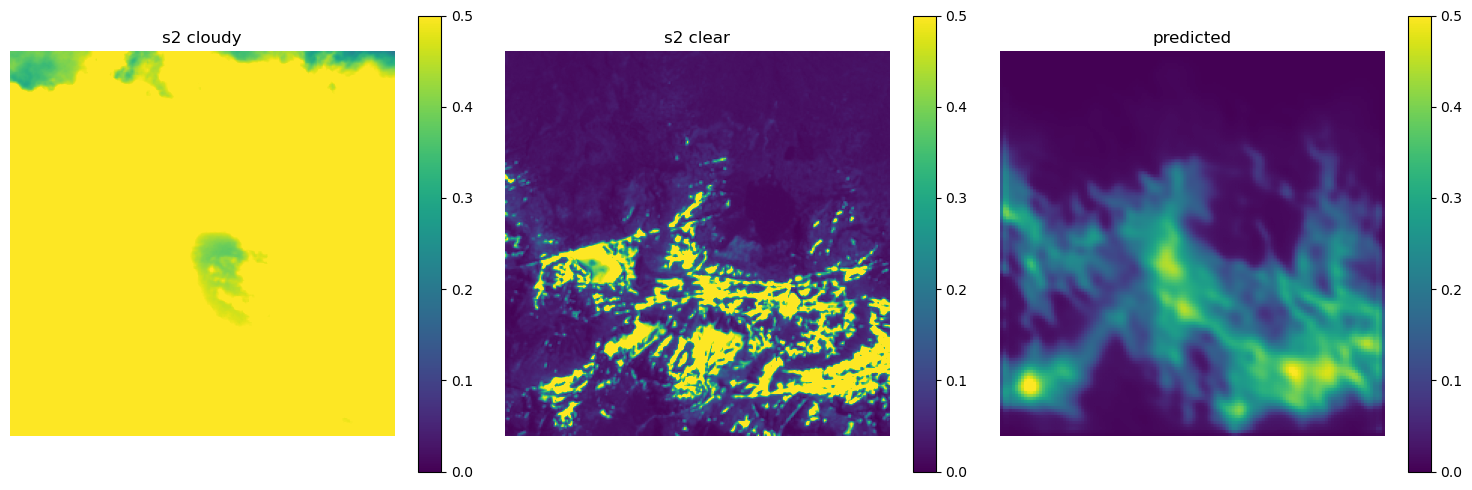

In [26]:
import matplotlib.pyplot as plt
import numpy as np
sample_test = 3
band = 0
# Create some sample images
image1 = s2_10_input[sample_test,band,:,:].cpu()  # s2 input
image2 = s2_10_output[sample_test,band,:,:].cpu()  # s2 output
image3 = y_hat[sample_test,band,:,:].cpu() # predicted

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot images on each subplot using imshow
im1 =axes[0].imshow(image1, cmap='viridis', vmin = 0 , vmax = 0.5)
axes[0].set_title('s2 cloudy')
cbar1 = plt.colorbar(im1, ax=axes[0])
axes[0].axis('off')

im2 = axes[1].imshow(image2, cmap='viridis', vmin = 0 , vmax = 0.5)
axes[1].set_title('s2 clear')
cbar2 = plt.colorbar(im2, ax=axes[1])
axes[1].axis('off')

im3 = axes[2].imshow(image3, cmap='viridis', vmin = 0 , vmax = 0.5)
axes[2].set_title('predicted')
cbar3 = plt.colorbar(im3, ax=axes[2])
axes[2].axis('off')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

# Use one image for training, valid and test

In [30]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import argparse
from tqdm import tqdm
import time
import os
import math
import random
from skimage.transform import resize
from scipy.ndimage import rotate

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import torchmetrics
from torchmetrics.image.psnr import PeakSignalNoiseRatio

#from model.networks.deeplabv3plus import DeepLabV3Plus
#from model.losses.loss import FocalTverskyLoss

from datetime import datetime

#from data.asbestos import AsbestosDataset

from sklearn.model_selection import train_test_split

from tools.utils import save_checkpoint, load_checkpoint

import warnings
warnings.filterwarnings("ignore")

# set flags / seeds
SEED = 5
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

## function
def to_tensor(x, **kwargs):
    return torch.from_numpy(x.transpose(2, 0, 1).astype('float32'))



class RandomCrop(object):
    def __init__(self, crop_size, p=0.5):
        self.crop_size = crop_size
        self.p = p

    def __call__(self, **data):
        image = data['image']
        mask = data['mask']

        if np.random.rand() <= self.p:
            h, w = image.shape[:2]
            new_h, new_w = self.crop_size
            top = np.random.randint(0, h - new_h)
            left = np.random.randint(0, w - new_w)

            image = image[top: top + new_h, left: left + new_w]
            mask = mask[top: top + new_h, left: left + new_w]

        return {'image': image, 'mask': mask}
    

class MyStructureMain:
    def __init__(self,lr, resume, data_dir, csv_file, path_to_checkpoint, path_to_save_models,epochs, batch_size, num_workers):
        
        self.lr = lr
        self.resume = resume
        self.data_dir = data_dir
        self.csv_file = csv_file
        self.path_to_checkpoint = path_to_checkpoint
        self.path_to_save_models = path_to_save_models
        self.epochs = epochs
        self.batch_size = batch_size
        self.num_workers = num_workers


# Create an instance of the "structure"
opt = MyStructureMain(1e-5, False, '/mnt/nvme1/dataset_S2A', '/data/mboumahdi/codes/18GXS_dataset_1.0_256_256.csv', 
                      '/mnt/nvme1/models_decloud/','/mnt/nvme1/models_decloud/', 300, 1,1 )

# Start with main code
if __name__ == '__main__':
    # argparse for additional flags for experiment
    df = pd.read_csv(opt.csv_file)
    df_train = df[df['set'] == 'train']
    df_valid = df[df['set'] == 'validation']
    df_test = df[df['set'] == 'test']
    
    image = 138
    
    df_train = df_train[image:image+1]
    df_test = df_train
    df_valid = df_train
    
    
    row_index=0
    num_duplicates = 1000 # Replace this with the desired number of duplicates

    # Extract the row to be duplicated
    row_to_duplicate = df_train.iloc[row_index:row_index + 1]

    # Create a list of duplicated rows
    duplicated_rows = [row_to_duplicate] * num_duplicates

    # Append the duplicated rows to the DataFrame
    df_train = pd.concat([df_train] + duplicated_rows, ignore_index=True)


    duplicated_rows = [row_to_duplicate] * 150
    df_test = pd.concat([df_test] + duplicated_rows, ignore_index=True)
    
    
    duplicated_rows = [row_to_duplicate] * 80
    df_valid = pd.concat([df_valid] + duplicated_rows, ignore_index=True)
    
    
    df_train = df_train.reset_index(drop=True)
    df_valid = df_valid.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    print(len(df_train))
    print(len(df_valid))
    print(len(df_test))

    
    #print(df_train)
    
    dataset_train = SentinelDataset(opt.data_dir, df_train['filename'], subset='train')  # You can adjust subset
    #dataset_test = dataset_train
    #dataset_valid = dataset_train
    dataset_test  = SentinelDataset(opt.data_dir, df_test['filename'], subset = 'test')  # You can adjust subset
    dataset_valid = SentinelDataset(opt.data_dir, df_valid['filename'], subset='valid')  # You can adjust subset

    dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True,
                                    drop_last=True, num_workers=opt.num_workers, pin_memory=True)
    dataloader_val = DataLoader(dataset_valid, batch_size=1, shuffle=False,
                                    num_workers=opt.num_workers, pin_memory=True)
    dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False,
                                    num_workers=opt.num_workers, pin_memory=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Sentinel12UNet().to(device)
    date = datetime.now().strftime('%Y-%m-%d_%f')
    
    project_name = 'Sentinel12UNet_One_Image_duplicate_'+str(image)
    
    writer = SummaryWriter(f'/mnt/nvme1/models_decloud/{project_name}', filename_suffix=project_name)
    s2_10 = torch.randn([1, 4, 64, 64]).to(device)
    s2_20 = torch.randn([1, 6, 64, 64]).to(device)
    s1_10 = torch.randn([1, 2, 64, 64]).to(device)
    dem_20 = torch.randn([1, 1, 32, 32]).to(device)
    writer.add_graph(model, input_to_model=(s2_10, s2_20, s1_10, dem_20))
    
    metric = PeakSignalNoiseRatio().to(device)
    criterion = nn.L1Loss()
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=opt.lr, weight_decay=1e-5)
# load checkpoint if needed/ wanted
    start_n_iter = 0
    start_epoch = 1
    if opt.resume:
        ckpt = load_checkpoint(opt.path_to_checkpoint)  # custom method for loading last checkpoint
        model.load_state_dict(ckpt['model'])
        start_epoch = ckpt['epoch']
        start_n_iter = ckpt['n_iter']
        optimizer.load_state_dict(ckpt['optim'])
        print("last checkpoint restored")

    # now we start the main loop
    n_iter = start_n_iter
    best_val_loss = np.inf
    patience = 5
    trigger_times = 0
    
    epochs = opt.epochs    
    
    for epoch in range(start_epoch, opt.epochs + 1):
        n_iter = n_iter + 1
        # set models to train mode
        model.train()

        # use prefetch_generator and tqdm for iterating through data
        pbar = tqdm(enumerate(dataloader_train),
                    total=len(dataloader_train))

        start_time = time.time()

        # for loop going through dataset
        running_train_loss = 0

        for i, data in pbar:
            s2_10_input = data['s2_10m_input'].to(device)
            s2_20_input = data['s2_20m_input'].to(device)
            s1_10 = data['s1_10m'].to(device)
            dem_20 = data['dem'].to(device)

            s2_10_output = data['s2_10m_output'].to(device)
            s2_20_output = data['s2_20m_output'].to(device)

            y = torch.cat([s2_10_output, s2_20_output], 1)

            # It's very good practice to keep track of preparation time and
            # computation time using tqdm to find any issues in your dataloader
            prepare_time = start_time - time.time()

            # forward and backward pass
            y_hat = model(s2_10_input, s2_20_input, s1_10, dem_20)

            loss = criterion(y_hat, y)  # TODO: check order parameters

            running_train_loss += loss.item()

            # backward
            optimizer.zero_grad(set_to_none=True)

            loss.backward()

            optimizer.step()

            # compute computation time and *compute_efficiency*
            process_time = start_time - time.time() - prepare_time
            compute_efficiency = process_time / (process_time + prepare_time)
            pbar.set_description(
                f'Train. Compute efficiency: {compute_efficiency:.2f}, '
                f'loss: {loss.item():.6f},  epoch: {epoch}/{epochs}')
            start_time = time.time()

        # update tensorboard
        writer.add_scalar("Loss/train", running_train_loss / len(dataloader_train), n_iter)

        model.eval()  # evaluation mode

        ###### Validation
        running_val_loss = 0.0
        running_val_acc = 0.0
        pbar = tqdm(enumerate(dataloader_val), total=len(dataloader_val))
        with torch.no_grad():
            for i, data in pbar:
                # data preparation
                s2_10_input = data['s2_10m_input'].to(device)
                s2_20_input = data['s2_20m_input'].to(device)
                s1_10 = data['s1_10m'].to(device)
                dem_20 = data['dem'].to(device)

                s2_10_output = data['s2_10m_output'].to(device)
                s2_20_output = data['s2_20m_output'].to(device)

                y = torch.cat([s2_10_output, s2_20_output], 1)

                y_hat = model(s2_10_input, s2_20_input, s1_10, dem_20)
                loss = criterion(y_hat, y)  # TODO: check order parameters

                acc_value = metric(y_hat, y)

                running_val_loss += loss.item()
                running_val_acc += acc_value

                pbar.set_description(
                    f'Validation. Loss: {loss.item():.6f}, accuracy: {acc_value:.6f}, epoch: {epoch}/{epochs}')

            writer.add_scalar("Loss/validation", running_val_loss / len(dataloader_val), n_iter)
            writer.add_scalar("Accuracy/validation", running_val_acc / len(dataloader_val), n_iter)
            '''  
            if running_val_loss >= best_val_loss:
                trigger_times += 1
                if trigger_times >= patience:
                    break
            elif running_val_loss < best_val_loss:
                best_val_loss = running_val_loss
                trigger_times = 0
                cpkt = {
                    'model': model.state_dict(),
                    'epoch': epoch,
                    'n_iter': n_iter,
                    'optim': optimizer.state_dict(),
                }
            
                '''
            best_val_loss = running_val_loss
            trigger_times = 0
            cpkt = {
                    'model': model.state_dict(),
                    'epoch': epoch,
                    'n_iter': n_iter,
                    'optim': optimizer.state_dict(),
                }
            if 1 == 1 :
           

                save_checkpoint(cpkt, os.path.join(opt.path_to_save_models, f'{project_name}.ckpt'))

                if epoch % 1 == 0:
                    pbar = tqdm(enumerate(dataloader_test), total=len(dataloader_test))

                    running_test_acc = 0.0
                    for i, data in pbar:
                        # data preparation
                        s2_10_input = data['s2_10m_input'].to(device)
                        s2_20_input = data['s2_20m_input'].to(device)
                        s1_10 = data['s1_10m'].to(device)
                        dem_20 = data['dem'].to(device)

                        s2_10_output = data['s2_10m_output'].to(device)
                        s2_20_output = data['s2_20m_output'].to(device)

                        y = torch.cat([s2_10_output, s2_20_output], 1)

                        y_hat = model(s2_10_input, s2_20_input, s1_10, dem_20)
                        loss = criterion(y_hat, y)  # TODO: check order parameters

                        acc_value = metric(y_hat, y)

                        running_test_acc += acc_value

                        pbar.set_description(
                            f'Test Accuracy: {acc_value:.6f},  epoch: {epoch}/{epochs}')

                    writer.add_scalar("Accuracy/test", running_test_acc / len(dataloader_test), n_iter)

                    num_figures = np.min((5, y_hat.shape[0]))
                    fig, axes = plt.subplots(nrows=num_figures, ncols=3, figsize=(12, int(3 * num_figures)), squeeze=False)
                    for idx in range(num_figures):
                        img_1 = np.rollaxis(np.squeeze(s2_10_input[idx][[2, 1, 0], :, :].cpu().numpy()), 0, 3)
                        axes[idx][0].imshow(np.clip(img_1, 0.0, 1.0))
                        axes[idx][0].set_axis_off()

                        img_2 = np.rollaxis(np.squeeze(s2_10_output[idx][[2, 1, 0], :, :].cpu().numpy()), 0, 3)
                        axes[idx][1].imshow(np.clip(img_2, 0.0, 1.0))
                        axes[idx][1].set_axis_off()

                        img_pred = np.rollaxis(np.squeeze(y_hat[idx][[2, 1, 0], :, :].cpu().numpy()), 0, 3)
                        axes[idx][2].imshow(np.clip(img_pred, 0.0, 1.0))
                        axes[idx][2].set_axis_off()
                    plt.tight_layout()

                    fig.canvas.draw()
                    img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
                    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                    img = np.swapaxes(img, 0, 2)

                    writer.add_image(f'test_{n_iter:0>4}', img, n_iter)
                    plt.close(fig)

1001
81
151


Train. Compute efficiency: 0.90, loss: 0.021305,  epoch: 1/300: 100%|██████████| 1001/1001 [00:23<00:00, 42.14it/s]
Validation. Loss: 0.021300, accuracy: 23.998177, epoch: 1/300: 100%|██████████| 81/81 [00:01<00:00, 55.49it/s]
Test Accuracy: 23.998177,  epoch: 1/300: 100%|██████████| 151/151 [00:02<00:00, 57.22it/s]
Train. Compute efficiency: 0.94, loss: 0.020096,  epoch: 2/300: 100%|██████████| 1001/1001 [00:23<00:00, 42.09it/s]
Validation. Loss: 0.020041, accuracy: 24.422743, epoch: 2/300: 100%|██████████| 81/81 [00:01<00:00, 54.41it/s]
Test Accuracy: 24.422743,  epoch: 2/300: 100%|██████████| 151/151 [00:02<00:00, 57.21it/s]
Train. Compute efficiency: 0.94, loss: 0.019631,  epoch: 3/300: 100%|██████████| 1001/1001 [00:24<00:00, 41.63it/s]
Validation. Loss: 0.019121, accuracy: 24.780682, epoch: 3/300: 100%|██████████| 81/81 [00:01<00:00, 53.14it/s]
Test Accuracy: 24.780682,  epoch: 3/300: 100%|██████████| 151/151 [00:02<00:00, 56.86it/s]
Train. Compute efficiency: 0.94, loss: 0.01887

KeyboardInterrupt: 

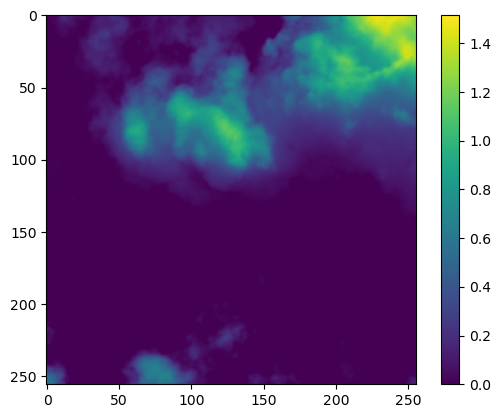

In [41]:
plt.imshow(img_1[:,:,0])
plt.colorbar()

In [ ]:
s2_10_input = data['']

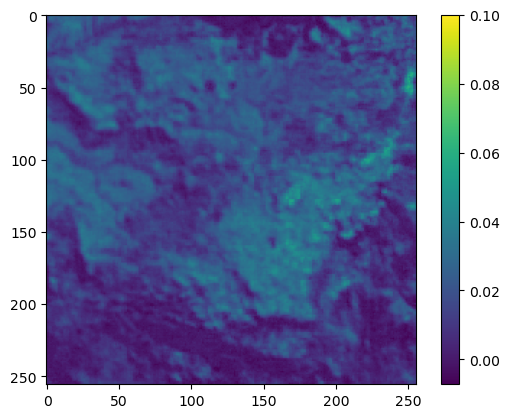

In [42]:
plt.imshow(img_pred[:,:,0], vmax = 0.1)
plt.colorbar()

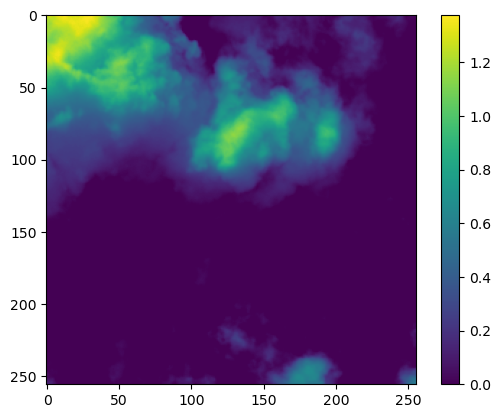

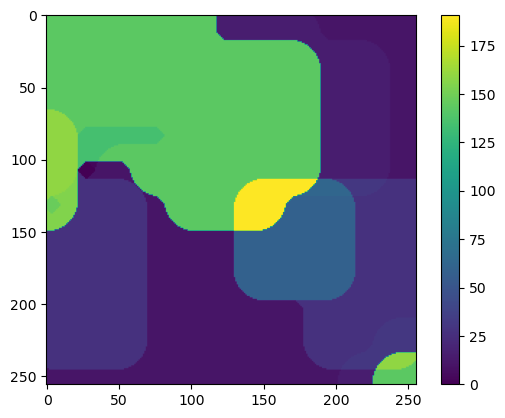

In [49]:
data = dataset_train[0]

s2_10m_input = data['s2_10m_input']
s2_10m_output = data['s2_10m_output']
s2_20m_input = data['s2_20m_input']
s2_20m_output = data['s2_20m_output']
s1_10m = data['s1_10m']
dem = data['dem']
cloud_mask = data['cloud_mask']


plt.imshow(s2_10m_input[0,...].numpy())
plt.colorbar()
plt.show()

plt.imshow(cloud_mask.numpy())
plt.colorbar()
plt.show()

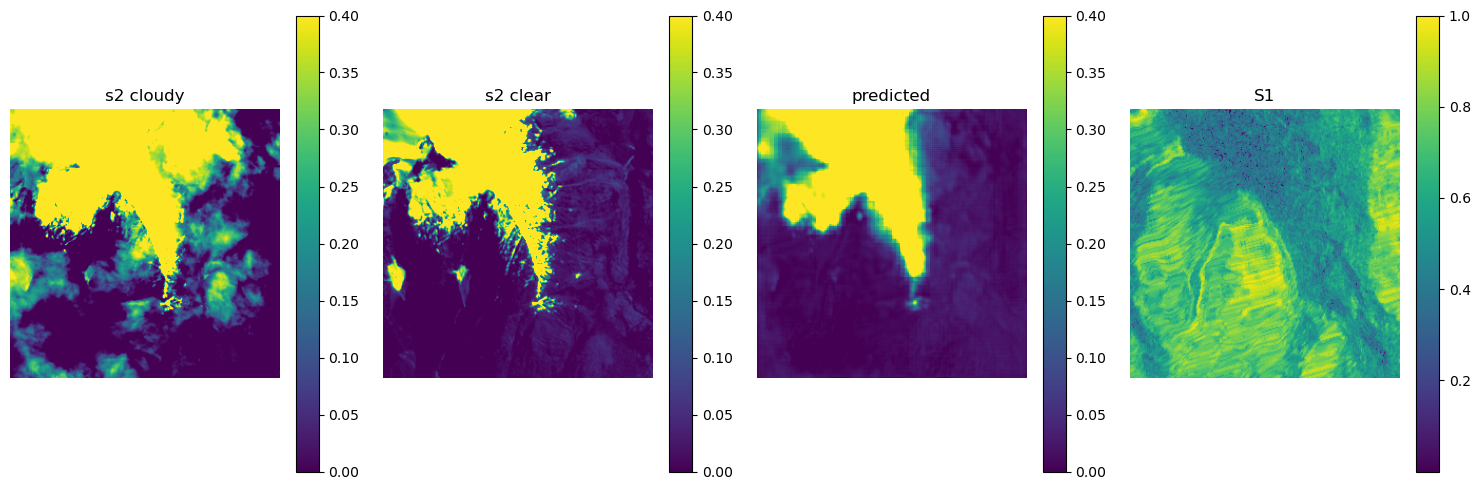

In [5]:
#Train. Compute efficiency: 0.15, loss: 0.057961,  epoch: 281/500: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]
#Validation. Loss: 0.059845, accuracy: 24.501375, epoch: 281/500: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

import matplotlib.pyplot as plt
import numpy as np
import cv2

# Create some sample images
image1 = s2_10_input[0,0,:,:].cpu()  # s2 input
image2 = s2_10_output[0,0,:,:].cpu()  # s2 output
image3 = y_hat[0,0,:,:].cpu() # predicted
image4 = s1_10[0,0,:,:].cpu()


#image1 = np.transpose(image1, (1, 2, 0))
#image2 = np.transpose(image2, (1, 2, 0))
#image3 = np.transpose(image3, (1, 2, 0))
# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

# Plot images on each subplot using imshow
im1 =axes[0].imshow(image1, cmap='viridis', vmin = 0 , vmax = 0.4)
axes[0].set_title('s2 cloudy')
cbar1 = plt.colorbar(im1, ax=axes[0])
axes[0].axis('off')

im2 = axes[1].imshow(image2, cmap='viridis', vmin = 0 , vmax = 0.4)
axes[1].set_title('s2 clear')
cbar2 = plt.colorbar(im2, ax=axes[1])
axes[1].axis('off')

im3 = axes[2].imshow(image3, cmap='viridis', vmin = 0 , vmax = 0.4)
axes[2].set_title('predicted')
cbar3 = plt.colorbar(im3, ax=axes[2])
axes[2].axis('off')

im4 = axes[3].imshow(image4, cmap='viridis')
axes[3].set_title('S1')
cbar4 = plt.colorbar(im4, ax=axes[3])
axes[3].axis('off')
# Adjust layout and display the figure
plt.tight_layout()
plt.show()

# Join csv files

In [12]:
import csv

# Read data from the first CSV file
csv_content1 = []
with open('18GXS_18GYS_dataset_1.0_256_256.csv', 'r', newline='') as file1:
    reader = csv.reader(file1)
    csv_content1.extend(list(reader))

# Read data from the second CSV file
csv_content2 = []
with open('18GXU_dataset_1.0_256_256.csv', 'r', newline='') as file2:
    reader = csv.reader(file2)
    csv_content2.extend(list(reader))

combined_csv_content = csv_content1 + csv_content2


with open('18GXS_18GYS_18GXU_dataset_1.0_256_256.csv', 'w', newline='') as combined_file:
    writer = csv.writer(combined_file)
    writer.writerows(combined_csv_content)

print(len(csv_content1))
print(len(csv_content2))
print(len(combined_csv_content))

6026
2541
8567


In [13]:
combined_csv_content

[['filename',
  's2_input',
  's1_input',
  's2_target',
  'cloud_s2_input',
  'cloud_s2_target',
  'x',
  'y',
  'date_s2',
  'set'],
 ['18GXS_20180210_7936_0',
  '/data/mboumahdi/S2/S2_PREPARE/S2A/T18GXS/SENTINEL2A_20180210-144258-288_L2A_T18GXS_C_V1-0/SENTINEL2A_20180210-144258-288_L2A_T18GXS_C_V1-0_FRE_10m.tif',
  '/data/mboumahdi/S1/S1_PREPARE/T18GXS/s1a_18GXS_vvvh_ASC_164_20180209t234129_from-10to3dB.tif',
  '/data/mboumahdi/S2/S2_PREPARE/S2A/T18GXS/SENTINEL2A_20180213-144334-804_L2A_T18GXS_C_V1-0/SENTINEL2A_20180213-144334-804_L2A_T18GXS_C_V1-0_FRE_10m.tif',
  '1.0',
  '0.0',
  '7936',
  '0',
  '20180210',
  'train'],
 ['18GXS_20180210_8192_0',
  '/data/mboumahdi/S2/S2_PREPARE/S2A/T18GXS/SENTINEL2A_20180210-144258-288_L2A_T18GXS_C_V1-0/SENTINEL2A_20180210-144258-288_L2A_T18GXS_C_V1-0_FRE_10m.tif',
  '/data/mboumahdi/S1/S1_PREPARE/T18GXS/s1a_18GXS_vvvh_ASC_164_20180209t234129_from-10to3dB.tif',
  '/data/mboumahdi/S2/S2_PREPARE/S2A/T18GXS/SENTINEL2A_20180213-144334-804_L2A_T18GXS_